# Predicting Stock Prices using LSTM Neural Networks

## Team Members

*   Yehya, Altamimi

### **Introduction (2pts)**

The project aims to predict stock prices using deep learning techniques. Stock price prediction is of significant interest to investors, financial analysts, and traders for making informed decisions. By accurately forecasting stock prices, investors can potentially optimize their investment strategies and maximize returns.

**Dataset Description (5 pts)**

The dataset comprises historical stock price data from various companies spanning from 2012. Each data point represents the daily closing price of a stock. The dataset is publicly available and sourced from financial data repositories such as Yahoo Finance

Importing Libraries

In [ ]:
import pandas as pd  # Data manipulation
import numpy as np  # Numerical operations
import yfinance as yf  # Fetching stock data
from sklearn.preprocessing import MinMaxScaler  # Scaling data
from keras.models import Sequential  # Neural network model
from keras.layers import Dense, LSTM, Dropout  # Layers for model architecture
from keras.callbacks import EarlyStopping  # Early stopping during model training
import matplotlib.pyplot as plt  # Data visualization
from datetime import timedelta  # Time manipulation


Technical Indictators for stock price prediction

In [18]:
# Define technical indicators within pandas
def rsi_calculation(data, window=14):
    change = data.diff()
    gain = change.where(change > 0, 0).fillna(0)
    loss = -change.where(change < 0, 0).fillna(0)
    average_gain = gain.rolling(window=window).mean()
    average_loss = loss.rolling(window=window).mean()
    rs = average_gain / average_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def macd_calculation(data, slow=26, fast=12):
    exp1 = data.ewm(span=fast, adjust=False).mean()
    exp2 = data.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span=9, adjust=False).mean()
    return macd, signal

def bollinger_bands(data, window=20, width=2):
    middle_band = data.rolling(window=window).mean()
    sd = data.rolling(window=window).std()
    upper_band = middle_band + (sd * width)
    lower_band = middle_band - (sd * width)
    return upper_band, middle_band, lower_band

Code Section for Loading the Dataset (3 pts)






In [19]:
# Download stock data from Yahoo Finance
# The first argument is the Ticker of the stock price
# The Start date could also be manually changed
df = yf.download('NVDA', start='2012-01-01', end=pd.Timestamp.now())

print(df['Close'].tail(10))  # Print the first 10 close prices

[*********************100%%**********************]  1 of 1 completed

Date
2024-04-11    906.159973
2024-04-12    881.859985
2024-04-15    860.010010
2024-04-16    874.150024
2024-04-17    840.349976
2024-04-18    846.710022
2024-04-19    762.000000
2024-04-22    795.179993
2024-04-23    824.229980
2024-04-24    796.770020
Name: Close, dtype: float64


In [20]:
# Calculate technical indicators
df['RSI'] = rsi_calculation(df['Close'])
df['MACD'], df['MACD Signal'] = macd_calculation(df['Close'])
df['Upper BBand'], df['Middle BBand'], df['Lower BBand'] = bollinger_bands(df['Close'])

In [21]:
# Scaling features for LSTM model
close_scaler = MinMaxScaler(feature_range=(0, 1))
df['Close_scaled'] = close_scaler.fit_transform(df[['Close']])

In [22]:
# Define training data size
training_data_len = int(np.ceil(len(df) * .95))

# Prepare the data for LSTM model with a larger look-back window
look_back = 120 # Increase look-back period
def create_dataset(dataset, look_back):
    x, y = [], []
    for i in range(look_back, len(dataset)):
        x.append(dataset[i-look_back:i])
        y.append(dataset[i])
    return np.array(x), np.array(y)

x_train, y_train = create_dataset(df['Close_scaled'][:training_data_len], look_back)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

**Model Description**

I selected a Long Short-Term Memory (LSTM) neural network for my project. LSTM networks are well-suited for sequential data like time series, as they can capture long-term dependencies. Our model consists of multiple LSTM layers followed by fully connected layers for prediction.

**Model Training and Validation**

I employed the Adam optimizer with a learning rate of 0.001 for training the model. The dataset was divided into training and validation sets using an 80-20 split. I used mean squared error (MSE) loss function to train the model. The model was trained for 15 epochs.


In [23]:
# Build the LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(look_back, 1)),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
model.fit(x_train, y_train, epochs=15, batch_size=32, validation_split=0.1,
          callbacks=[early_stopping], verbose=1)

Epoch 1/15
80/80 [==============================] - 25s 258ms/step - loss: 5.6142e-04 - val_loss: 3.9680e-04
Epoch 2/15
80/80 [==============================] - 18s 221ms/step - loss: 1.0950e-04 - val_loss: 5.0622e-04
Epoch 3/15
80/80 [==============================] - 18s 229ms/step - loss: 1.0675e-04 - val_loss: 6.9559e-04
Epoch 4/15
80/80 [==============================] - 17s 213ms/step - loss: 1.1457e-04 - val_loss: 4.0794e-04
Epoch 5/15
80/80 [==============================] - 17s 217ms/step - loss: 1.0556e-04 - val_loss: 2.6800e-04
Epoch 6/15
80/80 [==============================] - 20s 245ms/step - loss: 8.6186e-05 - val_loss: 8.0100e-04
Epoch 7/15
80/80 [==============================] - 17s 217ms/step - loss: 7.6059e-05 - val_loss: 2.4988e-04
Epoch 8/15
80/80 [==============================] - 19s 232ms/step - loss: 9.4579e-05 - val_loss: 3.4209e-04
Epoch 9/15
80/80 [==============================] - 17s 213ms/step - loss: 7.8750e-05 - val_loss: 2.3511e-04
Epoch 10/15
80/80 [

**The stock price prediction will look to 3 months in the future**

In [24]:
# Predicting 3 months into the future
future_days = 90
last_data = df['Close_scaled'][-look_back:].values
current_batch = last_data.reshape((1, look_back, 1))
future_predictions = []
for i in range(future_days):
    current_pred = model.predict(current_batch)[0]
    future_predictions.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

future_predictions = close_scaler.inverse_transform(future_predictions)

# Generate future dates and plot predictions
last_date = df.index[-1]
future_dates = [last_date + timedelta(days=i) for i in range(1, future_days + 1)]

1/1 [==============================] - 0s 49ms/step


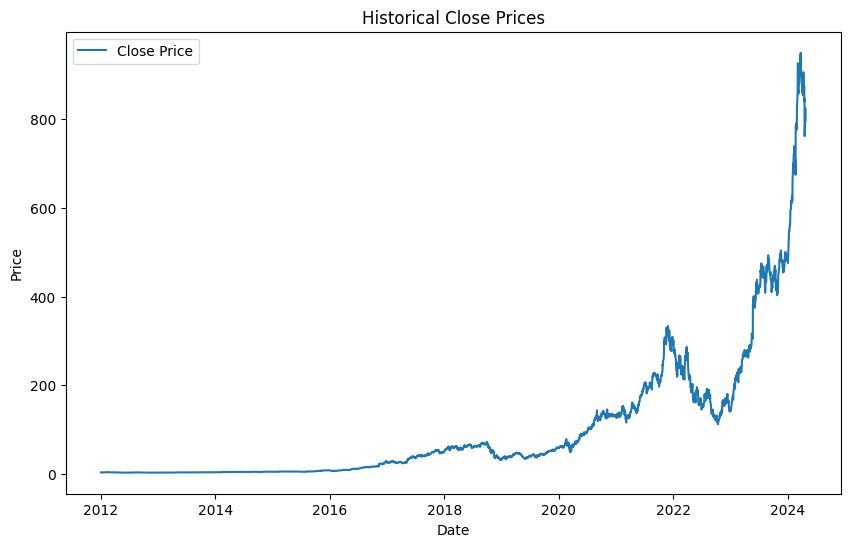

In [25]:
# Close prices since 2012 chart
plt.figure(figsize=(10, 6))
plt.plot(df['Close'], label='Close Price')
plt.title('Historical Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


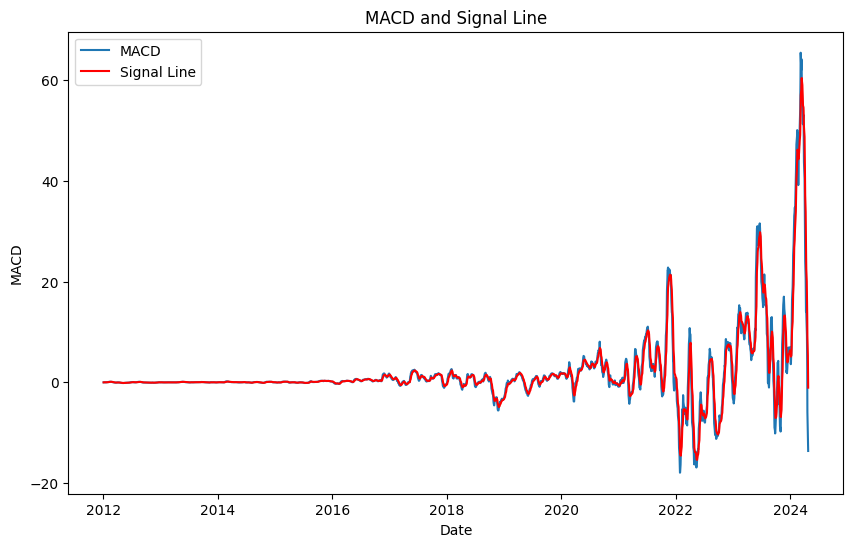

In [26]:
# Plot for MACD
plt.figure(figsize=(10, 6))
plt.plot(df['MACD'], label='MACD')
plt.plot(df['MACD Signal'], label='Signal Line', color='red')
plt.title('MACD and Signal Line')
plt.xlabel('Date')
plt.ylabel('MACD')
plt.legend()
plt.show()


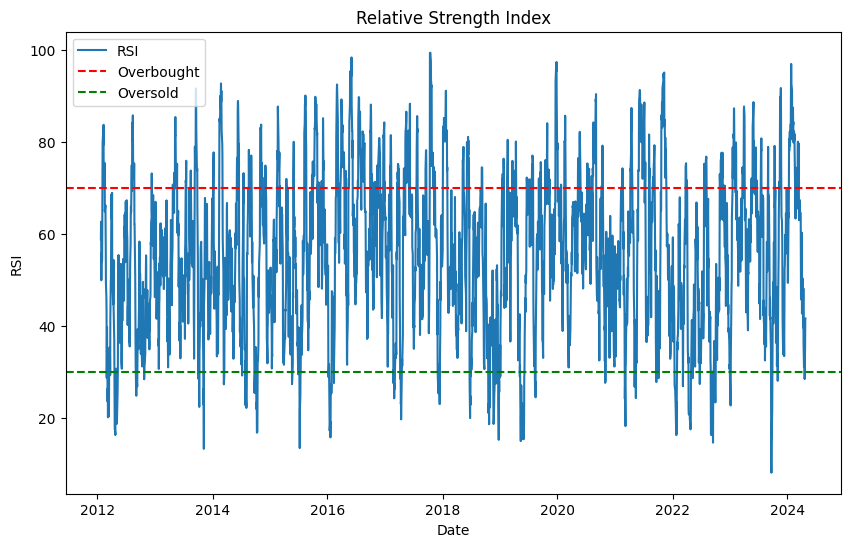

In [27]:
# Plot for RSI
plt.figure(figsize=(10, 6))
plt.plot(df['RSI'], label='RSI')
plt.axhline(70, linestyle='--', color='red', label='Overbought')
plt.axhline(30, linestyle='--', color='green', label='Oversold')
plt.title('Relative Strength Index')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.show()


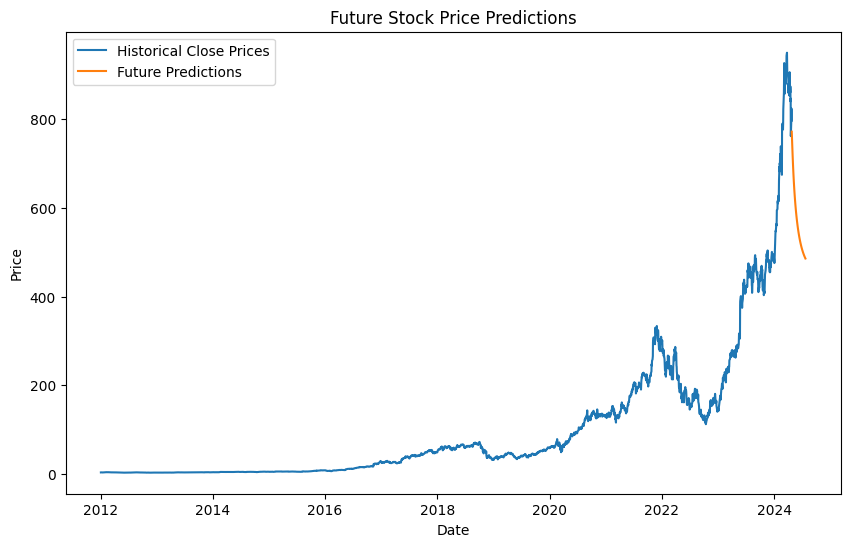

In [29]:
# Future price prediction 3 months out
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Close'], label='Historical Close Prices')
plt.plot(future_dates, future_predictions, label='Future Predictions')
plt.title('Future Stock Price Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


**Conclusion**

In conclusion, my project aimed to predict stock prices using deep learning techniques, particularly LSTM networks. While my model shows promise in predicting stock prices, further refinement and evaluation are necessary to enhance its accuracy and robustness.

**Contributions**

* Conducted thorough research on LSTM networks and their applications in stock price prediction.
* Implemented data preprocessing and model training pipeline.
* Explored various hyperparameters and optimization techniques to improve model performance.



